## Clustering & Classification: Olympic Atheletes

In this exercise, the task is to explore the olympic athelete dataset.

Features to start with:
 - Age
 - Height
 - Weight

Non-Features:
 - Sex (for splitting dataset)
 - Sport (for splitting dataset)
 - Year (for filtering NaN)
 - Medal (our truth comparison?)

Task:
- Split dataset by Sport
- Run classification algorithms to predict the medals won
- Try clustering algorithms to see if we can get the clusters to correlate to type of medals won.
  - KMeans
  - Gaussian Mixture Models
  - DBSCAN


## Dataset

https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results

Columns:

```
ID - Athelete ID
Name
Sex
Age
Height
Weight
Team
NOC - Code Name of Country (represented by the athelete)
Games - Which Olympic Games (year and city)
Year
Season - Winter or Summer Olympics
City - City that held the games
Sport - Sport
Event - Sport Event (e.g. Basketball finals)
Medal - Gold, Silver, Bronze, or NaN (for No Medal)
```

Note that there can be multiple entries per athelete, since an athelete can participate in multiple events, or return multiple years.

In [359]:
import pandas as pd
import matplotlib.pyplot as plt

## Explore Dataset

Features for partitioning the dataset:
 - Sport
 - Sex

Features to cluster:
 - Age
 - Height
 - Weight
 - Team
 - Year
 - Medal (this is our clustering comparison)

Data Processing
 - Convert NaN medals to 'None'
 - Drop rows earlier than 1960
   - because of too many missing Height and Weight values
   - see analysis here: https://www.kaggle.com/goldendime/advanced-techniques-for-dealing-w-missing-data
    - Fill other NaN values with mean (this is a crude interpolation)
 - Label Encode
 - Scale

In [360]:
df = pd.read_csv('D:/tmp/olympic-atheletes/athlete_events.csv',
                 usecols=['Age', 'Height', 'Weight',
                          'Team', 'Sex', 'Sport', 'Medal', 'Year'],
                 parse_dates=['Year'])
df.head()

,Sex,Age,Height,Weight,Team,Year,Sport,Medal
0,M,24.0,180.0,80.0,China,1992-01-01,Basketball,NaN
1,M,23.0,170.0,60.0,China,2012-01-01,Judo,NaN
2,M,24.0,NaN,NaN,Denmark,1920-01-01,Football,NaN
3,M,34.0,NaN,NaN,Denmark/Sweden,1900-01-01,Tug-Of-War,Gold
4,F,21.0,185.0,82.0,Netherlands,1988-01-01,Speed Skating,NaN


In [361]:
df.describe()

,Age,Height,Weight
count,261642.000000,210945.000000,208241.000000
mean,25.556898,175.338970,70.702393
std,6.393561,10.518462,14.348020
min,10.000000,127.000000,25.000000
25%,21.000000,168.000000,60.000000
50%,24.000000,175.000000,70.000000
75%,28.000000,183.000000,79.000000
max,97.000000,226.000000,214.000000


In [362]:
df.dtypes

Sex               object
Age              float64
Height           float64
Weight           float64
Team              object
Year      datetime64[ns]
Sport             object
Medal             object
dtype: object

In [363]:
df.Medal.unique()

array([nan, 'Gold', 'Bronze', 'Silver'], dtype=object)

In [364]:
# Convert NaN medals to 'None'

df['Medal'].fillna(value='None', inplace=True)

In [365]:
df.Medal.unique()

array(['None', 'Gold', 'Bronze', 'Silver'], dtype=object)

In [366]:
# Drop rows earlier than 1960
df.drop(index=df[df.Year < '1960'].index, inplace=True)

In [367]:
# check if there are still entries before 1960
print(df[df.Year < '1960'])

Empty DataFrame
Columns: [Sex, Age, Height, Weight, Team, Year, Sport, Medal]
Index: []


In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209072 entries, 0 to 271115
Data columns (total 8 columns):
Sex       209072 non-null object
Age       207957 non-null float64
Height    197953 non-null float64
Weight    197248 non-null float64
Team      209072 non-null object
Year      209072 non-null datetime64[ns]
Sport     209072 non-null object
Medal     209072 non-null object
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 14.4+ MB


In [369]:
# try to see if we can fill na using mean
mean_heights = pd.DataFrame(df.groupby(['Sport', 'Sex'])['Height'].mean())

mean_heights.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 97 entries, (Alpine Skiing, F) to (Wrestling, M)
Data columns (total 1 columns):
Height    97 non-null float64
dtypes: float64(1)
memory usage: 1.5+ KB


In [370]:
# Since all heights are available, let's fillna with them
# based on sport and gender
#
# fillna does nothing if the value isn't NaN, so it is
# safe to loop over and do a fillna per combination

for row in mean_heights.itertuples():
    sport = row.Index[0]
    gender = row.Index[1]
    height = row[1] # row.Height also works, but this is more generic
                    # and allows us to abstract this into a function
    
    # fillna inplace=True doesn't work because
    # somehow internally a copy is used and not a view (bug?)
    df.loc[(df.Sport == sport) & (df.Sex == gender), 'Height'] = \
        df.loc[(df.Sport == sport) & (df.Sex == gender), 'Height'].fillna(height)

In [371]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209072 entries, 0 to 271115
Data columns (total 8 columns):
Sex       209072 non-null object
Age       207957 non-null float64
Height    209072 non-null float64
Weight    197248 non-null float64
Team      209072 non-null object
Year      209072 non-null datetime64[ns]
Sport     209072 non-null object
Medal     209072 non-null object
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 14.4+ MB


In [372]:
# repeat the same process for weight and age
# define a helper function

def fillna_with_mean_by_sport_and_gender(df, column):
    """Fills NaN values using the mean value, grouped by
    sport and gender
    Args:
        df: dataframe to update
        column: column to fillna
    """
    means = pd.DataFrame(df.groupby(['Sport', 'Sex'])[column].mean())

    for row in means.itertuples():
        sport = row.Index[0]
        gender = row.Index[1]
        mean = row[1]
    
        # fillna inplace=True doesn't work because
        # somehow internally a copy is used and not a view (bug?)
        df.loc[(df.Sport == sport) & (df.Sex == gender), column] = \
            df.loc[(df.Sport == sport) & (df.Sex == gender), column].fillna(mean)

In [373]:
fillna_with_mean_by_sport_and_gender(df, 'Weight')
fillna_with_mean_by_sport_and_gender(df, 'Age')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209072 entries, 0 to 271115
Data columns (total 8 columns):
Sex       209072 non-null object
Age       209072 non-null float64
Height    209072 non-null float64
Weight    209072 non-null float64
Team      209072 non-null object
Year      209072 non-null datetime64[ns]
Sport     209072 non-null object
Medal     209072 non-null object
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 14.4+ MB


### Partition dataset and select features

In [337]:
# see which cluster we want to create by counting
# the number of entries
df.groupby(['Sport', 'Sex'])['Medal'].count()

Sport                  Sex
Alpine Skiing          F       2997
                       M       4588
Archery                F        974
                       M       1095
Athletics              F      10571
                       M      17521
Badminton              F        740
                       M        717
Baseball               M        894
Basketball             F       1256
                       M       2331
Beach Volleyball       F        276
                       M        288
Biathlon               F       1863
                       M       3030
Bobsleigh              F        143
                       M       2267
Boxing                 F         72
                       M       4589
Canoeing               F       1347
                       M       4212
Cross Country Skiing   F       3295
                       M       4806
Curling                F        222
                       M        225
Cycling                F       1394
                       M       6523
D

In [391]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot_pca(df, sport, gender):
    sport_df = df.loc[(df.Sport == sport) & (df.Sex == gender) & \
                      (df.Medal != 'None')]

    X = sport_df.loc[:, ['Height', 'Weight', 'Age']]
    medals = sport_df.Medal
    
    X_2d = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X))

    fig, ax = plt.subplots()
    
    medal_types = ['Gold', 'Silver', 'Bronze']
    colors = ['gold', 'silver', 'brown']

    for medal, color in zip(medal_types, colors):
        ax.scatter(X_2d[medals==medal, 0],
                   X_2d[medals==medal, 1],
                   color=color, label=medal)

    ax.set(title='PCA plot for %s, %s' % (sport, gender))
        
    ax.legend()

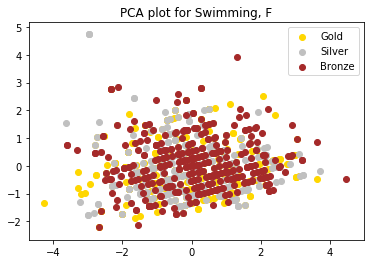

In [392]:
# Find a sport that we can cluster

plot_pca(df, 'Swimming', 'F')

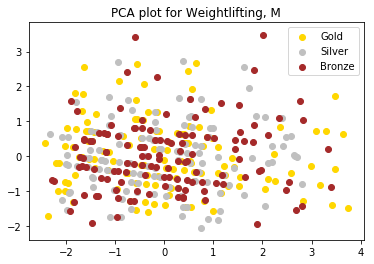

In [394]:
plot_pca(df, 'Weightlifting', 'M')

## Classification

## Clustering

Can we transform the dataset and then cluster?